In [1]:
import os
os.chdir('siesta_3')
import numpy as np
from sisl import *
import matplotlib.pyplot as plt
%matplotlib inline

# Siesta ---  creating initial DM input

This tutorial will describe how one can re-use a density matrix file (DM) from a primary unit-cell and tile it to create a bigger initial DM file for restart capabilities in bigger calculations.

The outline of the procedure is something like this:

1. Calculate the electronic structure (DM) for the primary cell of interest
2. Use `sisl` to read in the DM, then tile/repeate and manipulate the DM at will
3. Write out the finalized DM that will be used in the final calculation and restart the calculation.


## Creating the geometry

Our system of interest will be the smallest graphene cell, and we will expand it to a bigger one with an atom removed.

In [2]:
graphene = geom.graphene(1.44)

Let us plot the geometry.

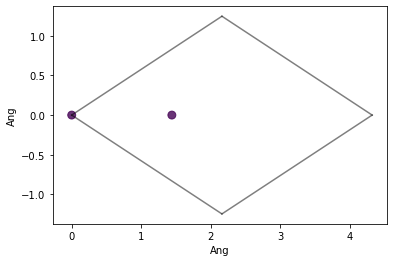

In [3]:
plot(graphene)

Now we need to create the input fdf file for Siesta:

In [4]:
open('RUN.fdf', 'w').write("""%include STRUCT.fdf
SystemLabel siesta_3
PAO.BasisSize SZP
MeshCutoff 250. Ry
CDF.Save true
CDF.Compress 9
SaveHS true
SaveRho true
%block kgrid.MonkhorstPack
  61  1 1 0.
   1 61 1 0.
   0  0 1 0.
%endblock
""")
graphene.write('STRUCT.fdf')

## Creating the electronic structure

Before proceeding, run Siesta to calculate the ground state electronic structure.

After having completed the Siesta run we may read the Hamiltonian to manipulate and extract different information.
After reading the Hamiltonian it is obvious that a great deal of new data has been associated with the Hamiltonian.

In [21]:
fdf = get_sile('RUN.fdf')
DM = fdf.read_density_matrix()
rij = DM.geometry.close(0, R=np.inf, ret_rij=True)[1]
print(np.sort(rij))
M_bulk = DM.geometry.atoms.group_atom_data(DM.mulliken())[0]

[ 0.          1.44        1.44        1.44        2.49415316  2.49415316
  2.49415316  2.49415316  2.49415316  2.49415316  2.88        2.88
  2.88        3.80988188  3.80988188  3.80988189  3.80988189  3.80988189
  3.80988189  4.32        4.32        4.32        4.32        4.32
  4.32        4.98830632  4.98830632  4.98830632  4.98830632  4.98830632
  4.98830632  5.19199383  5.19199383  5.19199383  5.19199383  5.19199384
  5.19199384  5.76        6.27681448  6.27681448  6.598909    6.598909
  6.598909    6.598909    7.2         8.01758068  8.01758068  8.64
  8.64       10.08      ]


## Creating the extended DM

In this case we will duplicate the primary graphene cell 4 times along each lattice vector, and then remove one atom.

In [23]:
DM_big = DM.tile(4, 0).tile(4, 1)
xyz_rem = DM_big.geometry.xyz[0, :]
DM_big = DM_big.remove(0)
g_big = DM_big.geometry

Now we have a much bigger geometry + its associated density matrix. However, when removing an atom one also removes electrons living in the overlap region of the basis sets; between the new geometry and the removed atom. This translates to a charge loss and should be compensated in the system.  
If Siesta reads in this DM *as is* it will compensate the charge in the entire cell. However, the most natural charge re-arrangement is typically close to the removed atom.  
First lets check how the charge distribution looks like with respect to the neutral atom. I.e. a big 

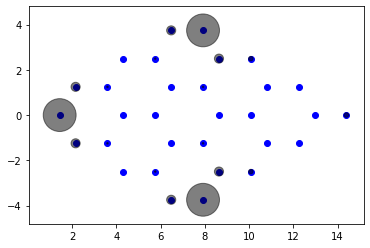

In [7]:
M = DM_big.mulliken("atom") - 4
plt.scatter(g_big.xyz[:, 0], g_big.xyz[:, 1], color='b')
# note we just scale enourmously.
plt.scatter(g_big.xyz[:, 0], g_big.xyz[:, 1], np.fabs(M) * 2000, color='k', alpha=0.5);

Let us print the total missing charge:

In [8]:
M.sum()

-1.3482183042176508

Which means we are ~1.3 short of an electron.

### Using atomic filling

When calculating the electronic structure using the default Siesta implementation you'll use *atomic fillings* for all orbitals. This will converge in approximately $106$ SCF steps.

### Correcting DM: Siesta rescaling

Lets first try to run without changing the DM and thus letting Siesta rescale the entire DM

In [9]:
DM_big.write("siesta_3_input.DM")
DM_big.geometry.write("STRUCT_BIG.fdf")
open('RUN_BIG.fdf', 'w').write("""%include STRUCT_BIG.fdf
SystemLabel siesta_3_big
PAO.BasisSize SZP
MeshCutoff 250. Ry
CDF.Save true
CDF.Compress 9
SaveHS true
SaveRho true
WriteMullikenPop 1
DM.UseSaveDM
%block kgrid.MonkhorstPack
  11  1 1 0.
   1 11 1 0.
   0  0 1 0.
%endblock
DM.MixingWeight 0.01
 """);

### Correcting DM: $p_z$

An attempt at correcting the DM will be to add the missing charges on each $p_z$ orbital in the system so that in total the system becomes charge-neutral.

In [10]:
DM_pz = DM_big.copy()
for ia in g_big:
    o = g_big.firsto[ia]
    atom = g_big.atoms[ia]
    orb = atom.index("pz") # retrive all orbitals with pz name in them
    DM_pz[o + orb, o + orb, 0] -= M[ia]

In [11]:
M_pz = DM_pz.mulliken("atom") - 4.
M_pz.sum()

-2.6278410558688847e-09

Write out the density matrix and restart a calculation using the faked DM:

In [12]:
DM_pz.write("siesta_3_pz.DM")
open('RUN_pz.fdf', 'w').write("""
SystemLabel siesta_3_pz
%include RUN_BIG.fdf
 """);

Now rerun `RUN_pz.fdf` and you'll find one convergence pattern. It converges in approximately $132$ steps.

### Correcting DM: $s$ and $p_z$

When running the above you'll see that it is still not an effective initial guess for the final DM, instead lets loop the orbitals and redistribute charge based on both $s$ and $p_z$

In [13]:
atoms_q = g_big.atoms.group_atom_data(DM_big.mulliken())

In [14]:
DM_spz = DM_big.copy()
for ia in g_big:
    o = g_big.firsto[ia]
    atom = g_big.atoms[ia]
    s = atom.index("s") # retrive all orbitals with pz name in them
    pz = atom.index("pz") # retrive all orbitals with pz name in them
    DM_spz[o + s, o + s, 0] -= M[ia] / 2
    DM_spz[o + pz, o + pz, 0] -= M[ia] / 2
print((DM_spz.mulliken("atom") - 4).sum())

-4.480255277883316e-09


In [16]:
DM_spz.write("siesta_3_spz.DM")
open('RUN_spz.fdf', 'w').write("""
SystemLabel siesta_3_spz
%include RUN_BIG.fdf
 """);

Now run `RUN_spz.fdf` and you'll find another convergence pattern. It converges in approximately $132$ steps.

### Correcting DM: range based

In reality the DM changes depending on the distance to the *hole* and as such we should change the charges based on this (a sort of ripple effect).

In [29]:
DM_range = DM_big.copy()
# Retrieve ranges
idxs = list(map(g_big.sc2uc, g_big.close(xyz_rem, R=(1.44, 2.5))))
missing = np.delete(np.arange(len(g_big)), np.hstack(idxs))

# nearest neighbours will have slightly less charge
for ia in idxs[0]:
    o = g_big.firsto[ia]
    atom = g_big.atoms[ia]
    s = atom.index("s")
    px = atom.index("px")
    py = atom.index("py")
    DM_range[o + s, o + s, 0] += 0.1
    DM_range[o + px, o + px, 0] -= 0.03
    DM_range[o + py, o + py, 0] -= 0.03

# next-nearest neighbours will have slightly more charge
for ia in idxs[1]:
    o = g_big.firsto[ia]
    atom = g_big.atoms[ia]
    pz = atom.index("pz")
    DM_range[o + pz, o + pz, 0] += 0.04

M_pz = DM_pz.mulliken("atom") - 4.
M_pz.sum()
DM

for ia in 
    o = g_big.firsto[ia]
    atom = g_big.atoms[ia]
    s = atom.index("s")
    px = atom.index("px")
    py = atom.index("py")
    DM_range[o + s, o + s, 0] += 0.1
    DM_range[o + px, o + px, 0] -= 0.05
    DM_range[o + py, o + py, 0] -= 0.05
print((DM_spz.mulliken("atom") - 4).sum())

[array([ 0, 24,  6], dtype=int32), array([ 1,  7, 23, 25,  5, 13], dtype=int32), array([30, 26, 14], dtype=int32)]
[ 2  3  4  8  9 10 11 12 15 16 17 18 19 20 21 22 27 28 29]
5.392873194469324
